# Data Preprocessing for UNSW-NB15 Dataset

---

Steps
1. Load data
2. Evaluate data
    - 2.1 Prepare/format data
    - 2.2 Deal with missing values
    - 2.3 Filter attack types (keep only DoS)
    - 2.4 Filter features (keep only what tcpdump/wireshark tools can replicate)
    - 2.5 Find/delete duplicate values
3. Balancing data
4. Prepare data for model
    - 4.1 Categorical features one-hot encoding
    - 4.2 Make data subsets
    - 4.3 Labels one-hot encoding
    - 4.4 Normalizing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

In [2]:
#Removes column of class labels from dataframe and saves into new array
def features_labels_split(data, label_column):
    features = data.copy()
    columns_titles = list(data.columns)
    features = features.reindex(columns=columns_titles)
    labels = features.pop(label_column)
    features = np.array(features)
    labels = np.array(labels)
    return features, labels

## 1. Load Data

---

In [3]:
#Load all 4 data files and concatenate them
dataframes = []
for i in range(4):
    file = pd.read_csv(f'data/UNSW-NB15_{i+1}.csv', delimiter = ",", header=None)
    dataframes.append(file)
data = pd.concat(dataframes, ignore_index=True)

C:\Users\kraus\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\kraus\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 2. Evaluating Data

---

### 2.1 Prepare/format data

In [4]:
#Rename columns
data.columns = ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'Label']

In [5]:
print('Number of data samples: ', len(data))

Number of data samples:  2540047


### 2.2 Deal with missing values
- Replace values that are not truly missing
- Delete true missing data

In [6]:
#Check which columns have missing values
nan_values = data.isna()
nan_columns = nan_values.any()
columns_with_nan = data.columns[nan_columns].tolist()

if len(columns_with_nan) != 0:
    print('Amount of null values in columns:')
    for col in columns_with_nan:
        print(f'\t{col}: {data[col].isna().sum()}')
else:
    print('No missing values in data')

Amount of null values in columns:
	ct_flw_http_mthd: 1348145
	is_ftp_login: 1429879
	attack_cat: 2218764


The dataset creators filled in 'NaN' under the feature 'attack_cat' for benign traffic since an attack category does not apply to normal traffic. This is not truly missing data and should be replaced with a 0 value to correspond to the benign class label.

Reference: *'DEEP-INTRUSION DETECTION SYSTEM WITH ENHANCED UNSW-NB15 DATASET BASED ON DEEP LEARNING TECHNIQUES', A.M. ALEESA, MOHAMMED YOUNIS, AHMED A. MOHAMMED, NAN M. SAHAR*


In [7]:
#Replace NaN with 0 for benign traffic attack category
data['attack_cat'] = data['attack_cat'].fillna(0)

In [8]:
#Verify that the previous code worked...
#attack_cat column should no longer have NaN values (all traffic is either benign with a 0 value or an attack w the corresponding label)
nan_values = data.isna()
nan_columns = nan_values.any()
columns_with_nan = data.columns[nan_columns].tolist()

if len(columns_with_nan) != 0:
    print('Amount of null values in columns:')
    for col in columns_with_nan:
        print(f'\t{col}: {data[col].isna().sum()}')
else:
    print('No missing values in data')

Amount of null values in columns:
	ct_flw_http_mthd: 1348145
	is_ftp_login: 1429879


In [9]:
#Check types and amounts of values of the first column with missing data
print(pd.unique(data['ct_flw_http_mthd']))
print(pd.value_counts(data['ct_flw_http_mthd'], dropna=False))

[ 0.  1.  2.  4. 14.  8.  6. 12. 10.  3.  5. 36.  9. nan 16. 25. 30.]
NaN     1348145
0.0      986791
1.0      188008
6.0        7902
4.0        6564
3.0         738
2.0         588
5.0         430
9.0         270
14.0        224
12.0        132
30.0         60
8.0          56
16.0         48
36.0         36
10.0         30
25.0         25
Name: ct_flw_http_mthd, dtype: int64


In [10]:
#Check types and amounts of values of the second column with missing data
print(pd.unique(data['is_ftp_login']))
print(pd.value_counts(data['is_ftp_login'], dropna=False))

[ 0.  1. nan  2.  4.]
NaN    1429879
0.0    1066593
1.0      43389
4.0        156
2.0         30
Name: is_ftp_login, dtype: int64


In [11]:
#Check types and amounts of values from attack_cat col to see what the effect will be per attack type after removing the missing data
print(pd.unique(data['attack_cat']))
print(pd.value_counts(data['attack_cat'], dropna=False))

[0 'Exploits' 'Reconnaissance' 'DoS' 'Generic' 'Shellcode' ' Fuzzers'
 'Worms' 'Backdoors' 'Analysis' ' Reconnaissance ' 'Backdoor' ' Fuzzers '
 ' Shellcode ']
0                   2218764
Generic              215481
Exploits              44525
 Fuzzers              19195
DoS                   16353
 Reconnaissance       12228
 Fuzzers               5051
Analysis               2677
Backdoor               1795
Reconnaissance         1759
 Shellcode             1288
Backdoors               534
Shellcode               223
Worms                   174
Name: attack_cat, dtype: int64


In [12]:
#Remove NaN values anywhere they appear in dataset
data = data.dropna(axis=0, how='any')

In [13]:
#Ensure that label column still has both classes
pd.unique(data['Label'])

array([0, 1], dtype=int64)

In [14]:
#Removing the columns with missing data removed lots of samples from DoS category
#Reduced from 16353 -> 1167
print(pd.unique(data['attack_cat']))
print(pd.value_counts(data['attack_cat'], dropna=False))

[0 'Exploits' 'Reconnaissance' 'DoS' 'Generic' 'Shellcode' ' Fuzzers'
 'Worms' 'Backdoors' 'Analysis']
0                 1064988
Generic              7522
Exploits             5409
 Fuzzers             5051
Reconnaissance       1759
DoS                  1167
Backdoors             534
Analysis              526
Shellcode             223
Worms                  24
Name: attack_cat, dtype: int64


In [15]:
#Ensure no more missing data
nan_values = data.isna()
nan_columns = nan_values.any()
columns_with_nan = data.columns[nan_columns].tolist()

if len(columns_with_nan) != 0:
    print('Amount of null values in columns:')
    for col in columns_with_nan:
        print(f'\t{col}: {data[col].isna().sum()}')
else:
    print('No missing values in data')

No missing values in data


In [16]:
print('Number of data samples remaining: ', len(data))

Number of data samples remaining:  1087203


### 2.3 Filter attack types

In [17]:
#Remove data that is not benign and not a DoS attack
data = data.drop(data[(data['attack_cat'] != 'DoS') & (data['attack_cat'] != 0)].index)

In [18]:
data

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,0,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,0,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,0,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,0,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087198,59.166.0.6,8647,149.171.126.8,25,tcp,CON,0.308446,31366,2566,31,...,0,1,1,2,1,1,1,1,0,0
1087199,59.166.0.2,4681,149.171.126.1,5190,tcp,FIN,0.006390,2054,2478,31,...,0,2,4,1,3,1,1,1,0,0
1087200,59.166.0.2,47560,149.171.126.2,6125,tcp,FIN,0.222470,8928,320,31,...,0,3,3,2,3,1,1,2,0,0
1087201,59.166.0.3,11047,149.171.126.5,80,tcp,CON,0.004158,890,8896,31,...,0,1,1,2,2,1,1,2,0,0


In [19]:
pd.unique(data['attack_cat']) #Verify attack category remaining - benign and DoS

array([0, 'DoS'], dtype=object)

In [20]:
print('Amount of data per attack category type:')
print(pd.value_counts(data['attack_cat']))

Amount of data per attack category type:
0      1064988
DoS       1167
Name: attack_cat, dtype: int64


### 2.4 Filter features

In [21]:
#remove data columns that we are not using for the model 
data = data.drop(columns=['attack_cat', 'srcip', 'dstip', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm'])
data.columns

Index(['sport', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl',
       'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts',
       'swin', 'dwin', 'stcpb', 'dtcpb', 'Label'],
      dtype='object')

### 2.5 Find/delete duplicate values

In [22]:
#check for duplicated values
print('before: \n', data.duplicated().value_counts())

data = data.drop_duplicates()

print('\nafter: \n', data.duplicated().value_counts())

before: 
 False    991178
True      74977
dtype: int64

after: 
 False    991178
dtype: int64


## 3. Balancing Data

---

In [23]:
#Make empty copy of original dataframe
balanced_data = data.copy()
balanced_data = balanced_data[0:0] #remove all rows keep column labels
balanced_data

,sport,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,...,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,Label


In [24]:
#add 2000 samples of normal traffic
normal = data.index[data['Label'] == 0].tolist()

for i in range(2000):
    balanced_data = balanced_data.append(data.loc[normal[i]])

balanced_data

,sport,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,...,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,Label
0,1390,53,udp,CON,0.001055,132,164,31,29,0,...,dns,5.004739e+05,6.218009e+05,2,2,0,0,0,0,0
1,33661,1024,udp,CON,0.036133,528,304,31,29,0,...,-,8.767609e+04,5.048017e+04,4,4,0,0,0,0,0
2,1464,53,udp,CON,0.001119,146,178,31,29,0,...,dns,5.218945e+05,6.362824e+05,2,2,0,0,0,0,0
3,3593,53,udp,CON,0.001209,132,164,31,29,0,...,dns,4.367246e+05,5.425972e+05,2,2,0,0,0,0,0
4,49664,53,udp,CON,0.001169,146,178,31,29,0,...,dns,4.995722e+05,6.090676e+05,2,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2079,49134,42815,udp,CON,0.001752,520,304,31,29,0,...,-,1.780822e+06,1.041096e+06,4,4,0,0,0,0,0
2080,1316,6881,tcp,FIN,25.146187,25368,1094788,31,29,38,...,-,8.052752e+03,3.478899e+05,452,858,255,255,3201368029,194316533,0
2081,7839,21,tcp,FIN,3.642744,2934,3740,31,29,11,...,ftp,6.320510e+03,8.062054e+03,52,54,255,255,773658637,919260853,0
2082,1061,53,udp,CON,0.000923,130,162,31,29,0,...,dns,5.633803e+05,7.020585e+05,2,2,0,0,0,0,0


In [25]:
#Verify there are 2000 samples under 'benign' or '0' label
print('Amount of data per attack category type:')
print(pd.value_counts(balanced_data['Label']))

Amount of data per attack category type:
0    2000
Name: Label, dtype: int64


In [26]:
#Add all the DoS data samples
dos = data.index[data['Label'] == 1].tolist()

for i in range(len(dos)):
    balanced_data = balanced_data.append(data.loc[dos[i]])

In [27]:
#One sample had an invalid dsport entry as a hex value (at index 196) should be deleted
balanced_data = balanced_data.drop(balanced_data[(balanced_data['dsport'] == '0xc0a8')].index)

In [28]:
#Verify final sample amounts
print('Amount of data per attack category type:')
print(pd.value_counts(balanced_data['Label']))

Amount of data per attack category type:
0    1999
1     748
Name: Label, dtype: int64


In [29]:
#Verify there are no duplicate values
balanced_data.duplicated().value_counts()

False    2747
dtype: int64

### Pie Chart for Class Balance

Before balancing data

In [30]:
#Prepare data for pie chart
class_counts = data['Label'].value_counts()
class_counts

0    990430
1       748
Name: Label, dtype: int64

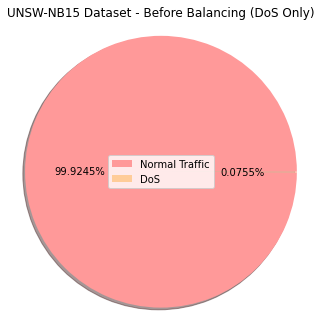

In [31]:
colors = ['#ff9999','#ffcc99']
plt.figure(figsize=(5, 5))
plt.pie(class_counts, autopct='%1.4f%%', radius=1.25, colors=colors, shadow=True)
plt.legend(labels=['Normal Traffic', 'DoS'], loc='center')
plt.title('UNSW-NB15 Dataset - Before Balancing (DoS Only)', y=1.05)
plt.savefig('img/data/full_data_class_balance_dos_only')

*pie chart for class balance of only DoS after balancing data is done in 'data_analysis.ipynb"*

In [32]:
#save data to csv file
balanced_data.to_csv('data/balanced_data.csv', index=False)

## 4. Prepare Data for Model

### 4.1 Categorical features one-hot encoding

In [33]:
#one hot encoding categorical columns: state, proto
proto = pd.get_dummies(balanced_data["proto"],prefix='proto')
service = pd.get_dummies(balanced_data["service"],prefix='service')
state = pd.get_dummies(balanced_data["state"],prefix='state')

balanced_data = balanced_data.merge(proto, how='outer', left_index=True, right_index=True)
balanced_data = balanced_data.merge(service, how='outer', left_index=True, right_index=True)
balanced_data = balanced_data.merge(state, how='outer', left_index=True, right_index=True)

In [37]:
balanced_data

,sport,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,...,service_pop3,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_FIN,state_INT,state_REQ,state_URH
0,1390,53,udp,CON,0.001055,132,164,31,29,0,...,0,0,0,0,0,1,0,0,0,0
1,33661,1024,udp,CON,0.036133,528,304,31,29,0,...,0,0,0,0,0,1,0,0,0,0
2,1464,53,udp,CON,0.001119,146,178,31,29,0,...,0,0,0,0,0,1,0,0,0,0
3,3593,53,udp,CON,0.001209,132,164,31,29,0,...,0,0,0,0,0,1,0,0,0,0
4,49664,53,udp,CON,0.001169,146,178,31,29,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183948,35369,80,tcp,FIN,0.289723,864,1390,254,252,2,...,0,0,0,0,0,0,1,0,0,0
184301,24841,25,tcp,FIN,1.012112,806,1096,254,252,5,...,0,0,0,0,0,0,1,0,0,0
184611,27333,143,tcp,FIN,1.206070,1010,4962,62,252,6,...,0,0,0,0,0,0,1,0,0,0
184663,25474,88,udp,CON,0.169691,2132,1512,254,60,0,...,0,0,0,0,0,1,0,0,0,0


In [34]:
balanced_data = balanced_data.drop(columns=['proto', 'state', 'service']) #Remove the original versions of the categorical cols
balanced_data

,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,...,service_pop3,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_FIN,state_INT,state_REQ,state_URH
0,1390,53,0.001055,132,164,31,29,0,0,500473.937500,...,0,0,0,0,0,1,0,0,0,0
1,33661,1024,0.036133,528,304,31,29,0,0,87676.085940,...,0,0,0,0,0,1,0,0,0,0
2,1464,53,0.001119,146,178,31,29,0,0,521894.531300,...,0,0,0,0,0,1,0,0,0,0
3,3593,53,0.001209,132,164,31,29,0,0,436724.562500,...,0,0,0,0,0,1,0,0,0,0
4,49664,53,0.001169,146,178,31,29,0,0,499572.250000,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183948,35369,80,0.289723,864,1390,254,252,2,2,21482.587890,...,0,0,0,0,0,0,1,0,0,0
184301,24841,25,1.012112,806,1096,254,252,5,4,5920.293457,...,0,0,0,0,0,0,1,0,0,0
184611,27333,143,1.206070,1010,4962,62,252,6,8,6327.991211,...,0,0,0,0,0,0,1,0,0,0
184663,25474,88,0.169691,2132,1512,254,60,0,0,75384.085940,...,0,0,0,0,0,1,0,0,0,0


In [35]:
#Check for duplicate values
balanced_data.duplicated().value_counts()

False    2747
dtype: int64

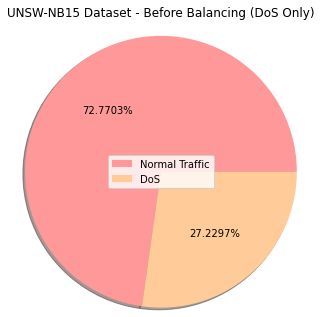

In [36]:
#Prepare data for pie chart
class_counts = balanced_data['Label'].value_counts()
class_counts

colors = ['#ff9999','#ffcc99']
plt.figure(figsize=(5, 5))
plt.pie(class_counts, autopct='%1.4f%%', radius=1.25, colors=colors, shadow=True)
plt.legend(labels=['Normal Traffic', 'DoS'], loc='center')
plt.title('UNSW-NB15 Dataset - Before Balancing (DoS Only)', y=1.05)
plt.savefig('img/data/full_data_class_balance_dos_only')

### 4.2 Make data subsets

In [41]:
#Separate data from the labels in the pandas dataframe into their own numpy arrays
x, y = features_labels_split(balanced_data, 'Label')

print(x.shape)
print(y.shape)

(2747, 165)
(2747,)


In [42]:
#Separate data into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, shuffle=True)

print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)
print('x_val shape: ', x_val.shape)
print('y_val shape: ', y_val.shape)

x_train shape:  (1922, 165)
y_train shape:  (1922,)
x_test shape:  (412, 165)
y_test shape:  (412,)
x_val shape:  (413, 165)
y_val shape:  (413,)


### 4.3 Labels one-hot encoding

In [43]:
#Label one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

print('y_train one-hot shape: ', y_train.shape)
print('y_val one-hot shape: ', y_val.shape)
print('y_test one-hot shape: ', y_test.shape)

y_train one-hot shape:  (1922, 2)
y_val one-hot shape:  (413, 2)
y_test one-hot shape:  (412, 2)


### 4.4 Normalizing

In [44]:
#Normalize Data
scaler = MinMaxScaler() 

x_train = scaler.fit_transform(x_train) 
x_val = scaler.transform(x_val) 
x_test = scaler.transform(x_test)

In [45]:
#Export data
np.savez('data/data.npz', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, x_val=x_val, y_val=y_val)